In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Construct toy dataset of positives and negatives with 2 variables

/Users/maghoi/opt/anaconda3/envs/py39/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

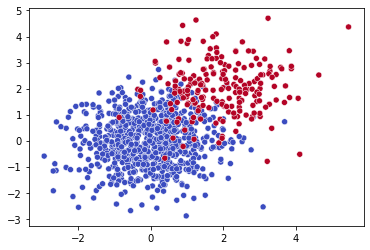

In [261]:
# Negatives
S = 200
x, y = 2, 2
X = np.random.normal(loc=x, scale=1.0, size=S)
Y = np.random.normal(loc=y, scale=1.0, size=S)
pos_x = np.vstack((X, Y)).T
pos_y = np.ones(S)

# Positives
S = 800
x, y = 0, 0
X = np.random.normal(loc=x, scale=1.0, size=S)
Y = np.random.normal(loc=y, scale=1.0, size=S)
neg_x = np.vstack((X, Y)).T
neg_y = np.zeros(S)

X_data = np.vstack((neg_x, pos_x))
y_data = np.concatenate((neg_y, pos_y))

# Feature engineering
#F = X_data**2
#X_data = np.hstack((X_data, F))

# Plot
sns.scatterplot(X_data[:, 0], X_data[:, 1], c=y_data, cmap="coolwarm")



In [329]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
    
def plot_decision_boundary_svc(model, X_data, y_data, ax=None):
    clf = model

    if ax is None:
        fig, ax = plt.subplots()
        
    # title for the plots
    title = ('Decision surface of linear SVC ')
    # Set-up grid for plotting.
    X0, X1 = X_data[:, 0], X_data[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_data, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('y label here')
    ax.set_xlabel('x label here')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

import sklearn.metrics as metrics
def get_auc(y_true, y_pred, sig_dig=5):
    """ Returns AUC """
    auc = np.round(metrics.roc_auc_score(y_true, y_pred), sig_dig)
    return auc

## Train an SVC classifier, get AUC performance and plot decision boundary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


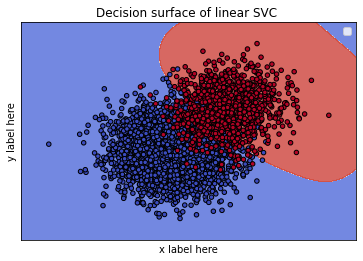

100% positives, AUC 0.95273


In [259]:
model = svm.SVC(kernel='rbf', probability=True)
clf = model.fit(X_data, y_data)

y_hat = clf.predict_proba(X_data)
y_hat = y_hat[:, 1]

plot_decision_boundary_svc(model, X_data, y_data)
auc = get_auc(y_data, y_hat)
print(f"100% positives, AUC {auc}")

## Test: Train on 5 % of data, get performance on original dataset

Pos: 0.01, 10, Neg 0.01,  10
10.0 20
0.95983


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


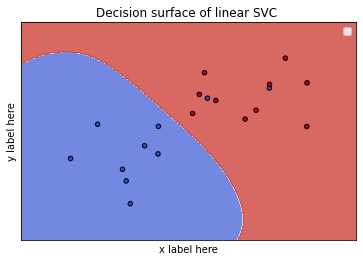

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

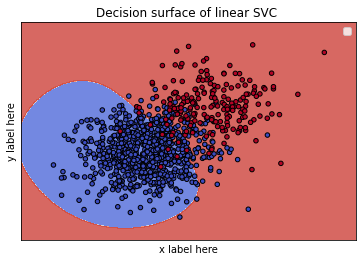

<Figure size 432x288 with 0 Axes>

In [403]:
# Number of iterations
frac_pos = 0.05
neg_factor = 1

clf, X_sub, y_sub = fit_PU(X_data, y_data, frac_pos, neg_factor, verbose=True, return_sub=True)
print(y_sub.sum(), len(y_sub))

# Predict on original data
y_hat = pred_PU(clf, X_data)
auc = get_auc(y_data, y_hat)
print(auc)

# Plot for subset
plot_decision_boundary_svc(clf, X_sub, y_sub)
plt.savefig("figures/PU_training_subset.pdf")

plot_decision_boundary_svc(clf, X_data, y_data)
plt.savefig("figures/PU_training_original_dataset.pdf")


## Test PU training

In [404]:
def fit_discard_positives(X_data, y_data, frac_pos, neg_factor):
    pos = np.where(y_data == 1)[0]
    np.random.shuffle(pos)
    selected_pos = pos[ :int(len(pos)*frac_pos) ]

    neg = np.where(y_data == 0)[0]
    np.random.shuffle(neg)
    selected_neg = neg[ : int(len(selected_pos)*neg_factor) ]

    X_data_sub = np.concatenate((X_data[selected_neg], X_data[selected_pos]))
    y_data_sub = np.concatenate((y_data[selected_neg], y_data[selected_pos]))

    model = svm.SVC(kernel='rbf', probability=True)
    clf = model.fit(X_data_sub, y_data_sub)

    return clf

def fit_PU(X_data, y_data, frac_pos, neg_factor, return_sub=False, verbose=False):
    pos = np.where(y_data == 1)[0]
    np.random.shuffle(pos)
    selected_pos = pos[ :int(len(pos)*frac_pos) ]

    # Remaining as unlabelled or negative
    idxs = np.array(range(len(y_data)))
    neg = np.delete(idxs, selected_pos)
    #neg = np.where(y_data == 0)[0]
    #np.random.shuffle(neg)
    selected_neg = neg[ : int(len(selected_pos)*neg_factor) ]

    if verbose:
        print(f"Pos: {len(selected_pos) / len(y_data)}, {len(selected_pos)}, Neg {len(selected_neg) / len(y_data)},  {len(selected_neg)}")

    X_data_sub = np.concatenate((X_data[selected_neg], X_data[selected_pos]))
    y_data_sub = np.concatenate((np.zeros(len(selected_neg)), np.ones(len(selected_pos))))

    model = svm.SVC(kernel='rbf', probability=True)
    clf = model.fit(X_data_sub, y_data_sub)

    if return_sub:
        return clf, X_data_sub, y_data_sub
    else:
        return clf

def pred_PU(clf, X_data):
    y_hat = clf.predict_proba(X_data)
    y_hat = y_hat[:, 1]

    return y_hat



## Test adjusting positive ratio used for training single model

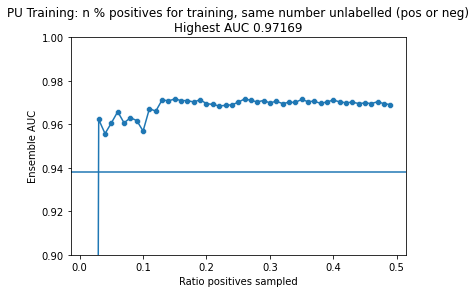

In [391]:
# Neg factor
#frac_pos = 0.20
r_frac_pos = np.arange(0.01, 0.50, 0.01)
neg_factor = 1
#r_neg_factor = np.arange(0.20, 5.01, 0.20)
r_iterations = range(1, 10, 1)
df_stats = pd.DataFrame(columns=r_iterations)

for frac_pos in r_frac_pos:
    y_out = np.zeros(len(y_data))
    for i in r_iterations:
        clf = fit_PU(X_data, y_data, frac_pos, neg_factor)
        y_hat = pred_PU(clf, X_data)
        y_out += y_hat
        
    # Final AUC
    auc = get_auc(y_data, y_out/(i+1))
    df_stats.loc[0, frac_pos] = auc

ax = sns.lineplot(y=df_stats.iloc[0, :], x=df_stats.columns)
sns.scatterplot(y=df_stats.iloc[0, :], x=df_stats.columns)

mean = df_stats.mean().mean()
plt.axhline(mean)
plt.ylim(0.90, 1.00)

plt.xlabel("Ratio positives sampled")
plt.ylabel("Ensemble AUC")

plt.title(f"PU Training: n % positives for training, same number unlabelled (pos or neg)\nHighest AUC {df_stats.max().max()}")
plt.savefig("figures/PU_neg_factor_1.pdf")

## Test discarding positives instead of PU training

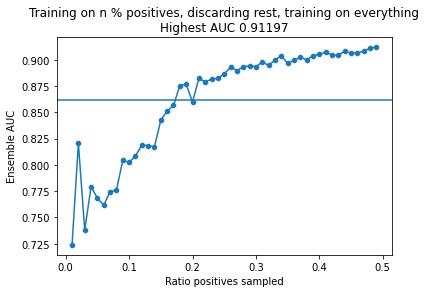

In [392]:
# Neg factor
#frac_pos = 0.20
r_frac_pos = np.arange(0.01, 0.50, 0.01)
neg_factor = 1000
#r_neg_factor = np.arange(0.20, 5.01, 0.20)
r_iterations = range(1, 5, 1)
df_stats = pd.DataFrame(columns=r_iterations)

for frac_pos in r_frac_pos:
    y_out = np.zeros(len(y_data))
    for i in r_iterations:
        clf = fit_discard_positives(X_data, y_data, frac_pos, neg_factor)
        y_hat = pred_PU(clf, X_data)
        y_out += y_hat
        
    # Final AUC
    auc = get_auc(y_data, y_out/(i+1))
    df_stats.loc[0, frac_pos] = auc

ax = sns.lineplot(y=df_stats.iloc[0, :], x=df_stats.columns)
sns.scatterplot(y=df_stats.iloc[0, :], x=df_stats.columns)

mean = df_stats.mean().mean()
plt.axhline(mean)
#plt.ylim(0.90, 1.00)

plt.xlabel("Ratio positives sampled")
plt.ylabel("Ensemble AUC")

plt.title(f"Training on n % positives, discarding rest, training on everything\nHighest AUC {df_stats.max().max()}")
plt.savefig("figures/discard_pos.pdf")

## Test adjusting pos:neg ratio during PU training

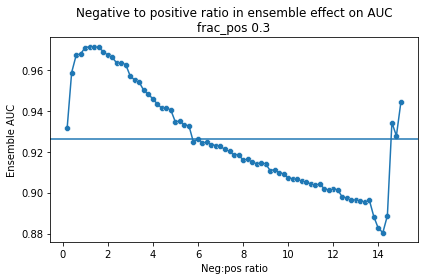

In [401]:
# Neg factor
frac_pos = 0.30
#neg_factor = 1
r_neg_factor = np.arange(0.20, 15.01, 0.20)
r_iterations = range(1, 30, 1)
df_stats = pd.DataFrame(columns=r_iterations)

for neg_factor in r_neg_factor:
    y_out = np.zeros(len(y_data))
    for i in r_iterations:
        clf = fit_PU(X_data, y_data, frac_pos, neg_factor)
        y_hat = pred_PU(clf, X_data)

        y_out += y_hat
        auc = get_auc(y_data, y_out/(i+1))
        
    # Final AUC
    df_stats.loc[0, neg_factor] = auc

ax = sns.lineplot(y=df_stats.iloc[0, :], x=df_stats.columns)
sns.scatterplot(y=df_stats.iloc[0, :], x=df_stats.columns)

mean = df_stats.mean().mean()
plt.axhline(mean)

plt.xlabel("Neg:pos ratio")
plt.ylabel("Ensemble AUC")

plt.title(f"Negative to positive ratio in ensemble effect on AUC\nfrac_pos {frac_pos}")

plt.tight_layout()
plt.savefig("figures/neg_frac__2.pdf")

## Test effect of training an ensemble with n % positives i times

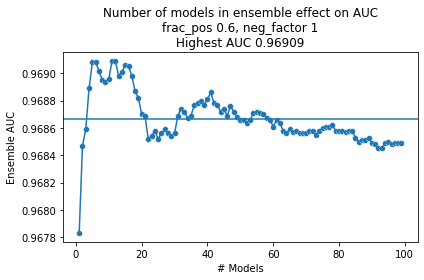

In [389]:
# Number of iterations
frac_pos = 0.60
neg_factor = 1
r_iterations = range(1, 100, 1)
df_stats = pd.DataFrame(columns=r_iterations)

y_out = np.zeros(len(y_data))
for i in r_iterations:
    clf = fit_PU(X_data, y_data, frac_pos, neg_factor)
    y_hat = pred_PU(clf, X_data)

    y_out += y_hat
    auc = get_auc(y_data, y_out/(i+1))
    df_stats.loc[0, i] = auc

ax = sns.lineplot(y=df_stats.iloc[0, :], x=df_stats.columns)
sns.scatterplot(y=df_stats.iloc[0, :], x=df_stats.columns)

mean = df_stats.mean().mean()
plt.axhline(mean)

plt.xlabel("# Models")
plt.ylabel("Ensemble AUC")

plt.title(f"Number of models in ensemble effect on AUC\nfrac_pos {frac_pos}, neg_factor {neg_factor}\nHighest AUC {df_stats.max().max()}")

plt.tight_layout()
plt.savefig("figures/model_count_auc.pdf")


## Test using all negatives during training

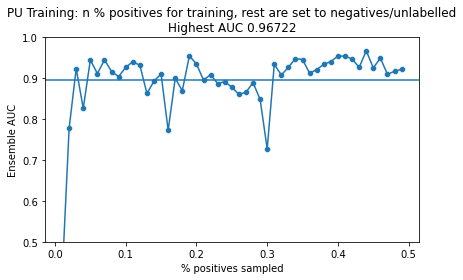

In [390]:
# Neg factor
#frac_pos = 0.20
r_frac_pos = np.arange(0.01, 0.50, 0.01)
neg_factor = 1000
#r_neg_factor = np.arange(0.20, 5.01, 0.20)
r_iterations = range(1, 10, 1)
df_stats = pd.DataFrame(columns=r_iterations)

for frac_pos in r_frac_pos:
    y_out = np.zeros(len(y_data))
    for i in r_iterations:
        clf = fit_PU(X_data, y_data, frac_pos, neg_factor)
        y_hat = pred_PU(clf, X_data)
        y_out += y_hat
        
    # Final AUC
    auc = get_auc(y_data, y_out/(i+1))
    df_stats.loc[0, frac_pos] = auc

ax = sns.lineplot(y=df_stats.iloc[0, :], x=df_stats.columns)
sns.scatterplot(y=df_stats.iloc[0, :], x=df_stats.columns)

mean = df_stats.mean().mean()
plt.axhline(mean)
plt.ylim(0.50, 1.00)

plt.xlabel("Ratio positives sampled")
plt.ylabel("Ensemble AUC")

plt.title(f"PU Training: n % positives for training, rest are set to negatives/unlabelled\nHighest AUC {df_stats.max().max()}")

plt.tight_layout()
plt.savefig("figures/PU_all_negs.pdf")